In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import uproot
import h5py as h
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import statistics as st
import os
import pickle
import glob
from scipy import stats
%matplotlib inline
import random
import seaborn as sn
from IPython.display import display, HTML
from scipy.stats import norm
import pandas as pd
import scipy.optimize as opt
display(HTML("<style>.container { width:90% !important; }</style>"))

font = {'family' : 'Ubuntu',
        'weight' : 'bold',
        'size'   : 20}

matplotlib.rc('font', **font)


In [2]:
def Get_hit_array(file, Current_Event,particle):
    data = h.File(file,'r')
    TotalEvents=int(data['MC']['configuration'][2][1])
    if(TotalEvents < Current_Event):
        print('out of event range')

    Current_Hit_Mask = data['MC']['hits']['event_id'] == Current_Event 
    Current_Particle_Mask = data["MC"]['particles']['event_id'] == Current_Event
    Hits_PIDs=data['MC']['hits'][Current_Hit_Mask]['particle_id'] 
    Current_Particles=data['MC']['particles'][Current_Particle_Mask]

    Electron_Mask = Current_Particles['particle_name'] == particle

    Electron_PIDS = data['MC']['particles'][Current_Particle_Mask][Electron_Mask]['particle_id']         


    Hit_Electron_Maks = np.in1d(Hits_PIDs, Electron_PIDS)
    ElectronData=data['MC']['hits'][Current_Hit_Mask][Hit_Electron_Maks]

    return ElectronData


def Diffuser(HIT_ARRAY,ZOFFSET):
    Etotal = 0
    Diffused_X = np.array([])
    Diffused_Y = np.array([])
    Diffused_Z = np.array([])
    GasProps.RegularUnits()
    for hit in HIT_ARRAY:
        energy_deposit = hit['energy']
        electron_loc_x = hit['x']/10
        electron_loc_y = hit['y']/10
        #electron_loc_z = hit['z']/10 + Zoffset
        electron_loc_z = ZOFFSET

        Etotal += energy_deposit

        Nelectron = int( (energy_deposit*1e6/GasProps.Wvalue) );

        # Loop through the electrons 
        for electron in range(Nelectron):

            # calculate drift time for diffusion 
            T_drift = electron_loc_z / GasProps.Vd
            if (T_drift <=0):
                print("Warnign T_drift is negative")
                continue
            # electron lifetime
            if (np.random.uniform() >= np.exp(-T_drift/GasProps.Life_Time)):
                continue

            # diffuse the electrons position
            sigma_T = np.sqrt(2*GasProps.Dt*T_drift)
            sigma_L = np.sqrt(2*GasProps.Dl*T_drift)
            electron_x = np.random.normal(electron_loc_x,sigma_T)
            electron_y = np.random.normal(electron_loc_y,sigma_T)
            electron_z = np.random.normal(electron_loc_z,sigma_L)
            Diffused_X=np.append(Diffused_X,electron_x)
            Diffused_Y=np.append(Diffused_Y,electron_y)
            Diffused_Z=np.append(Diffused_Z,electron_z)
    print("evnet has {} MeV and made {} electrons".format(round(Etotal,3), len(Diffused_X)))
        
        
    return Diffused_X, Diffused_Y, Diffused_Z




def Diffuserv2(HIT_ARRAY,ZOFFSET):
    Etotal = 0
    Diffused_X = []
    Diffused_Y = []
    Diffused_Z = []

    for hit in HIT_ARRAY:
        energy_deposit = hit[3]
        electron_loc_x = hit[0]
        electron_loc_y = hit[1]
        #electron_loc_z = hit[2] + Zoffset
        electron_loc_z = ZOFFSET

        Etotal += energy_deposit

       
        # calculate drift time for diffusion 
        T_drift = electron_loc_z / GasProps.Vd
        if (T_drift <=0):
            print("Warnign T_drift is negative")
            continue
        # electron lifetime
        if (np.random.uniform() >= np.exp(-T_drift/GasProps.Life_Time)):
            continue

        # diffuse the electrons position
        sigma_T = np.sqrt(2*GasProps.Dt*T_drift)
        sigma_L = np.sqrt(2*GasProps.Dl*T_drift)
        electron_x = np.random.normal(electron_loc_x,sigma_T)
        electron_y = np.random.normal(electron_loc_y,sigma_T)
        electron_z = np.random.normal(electron_loc_z,sigma_L)
        Diffused_X.append(electron_x)
        Diffused_Y.append(electron_y)
        Diffused_Z.append(electron_z)
    print("evnet has {} MeV and made {} electrons".format(round(Etotal,3), len(Diffused_X)))
        
        
    return Diffused_X, Diffused_Y, Diffused_Z


def ionizationElectronPosition(data,mother,targetvolume='EL_GAP',EventLimit=2):
    TotalEvents=int(data['configuration'][2][1])
    values={}

    
    if(EventLimit>TotalEvents):
        EventLimit=TotalEvents
        
    for EventID in range(0,EventLimit):
        # obtain current event id
        EventIDMask=data["particles"]["event_id"]==EventID
        
        #store particle infor for this event
        ParticlesTable=data["particles"][EventIDMask]
        # Create Mother mask for expected mother
        MotherMask=ParticlesTable["particle_name"]==mother
        # Interested particles
        IonizationElectronsMask=ParticlesTable["final_volume"]==targetvolume
        #obtain mother idsprint(ParticlesInInterest["particle_name"][IonizationElectronsMask][MotherIDMask])
        IonizationElectronMotherID=ParticlesTable["mother_id"][IonizationElectronsMask]
        #Expected Mother IDs
        ExpectedMotherID=ParticlesTable["particle_id"][MotherMask]
        # Find intersection of the motherIds of ie and Expected Mother
        MotherIDMask=np.isin(IonizationElectronMotherID,ExpectedMotherID)
        FinalPositions=[ParticlesTable["final_x"][IonizationElectronsMask][MotherIDMask],ParticlesTable["final_y"][IonizationElectronsMask][MotherIDMask],ParticlesTable["final_z"][IonizationElectronsMask][MotherIDMask]]
        values[EventID]=FinalPositions
    return values
        
def getvalues(file):
    data = h.File(file,'r')
    return data['MC']
                
    
class Gas_Properties():
    # gas values for 500V/cm at 10 bar
    # simulated from PyBoltz
    def __init__(self):
        #self.Wvalue = 22.1 # in eV
        #self.Vd = 935000.0 # cm/s
        #self.Dt = 6114.291 # cm**2/s
        #self.Dl = 506.464  # cm**2/s
        #self.Life_Time = 0.001 # in s
        
        self.Wvalue = 22.1 # in eV
        self.Life_Time = 0.001 # in s

    def RegularUnits(self):
        self.Vd = 94000 # cm/s
        self.Dt = 395.80 # cm**2/s
        self.Dl = 61.15  # cm**2/s
        
    def NextUnits(self):
        self.Vd = 0.9 # mm/us
        self.Dt = 0.92 # mm/sqrt(cm)
        self.Dl = 0.36  # mm/sqrt(cm)
    
    def Print(self):
        print(f"Wvalue is {self.Wvalue}")
        print(f"Electron LifeTime is {self.Life_Time}")
        print(f"Drift Velocity is {self.Vd}")
        print(f"Transverse Dif is {self.Dt}")
        print(f"Drift Velocity is {self.Vd}")
        print(f"Longitutional Dif is {self.Dl}")

        
        
        
GasProps = Gas_Properties()


def PickleITDump(data,fileName):
    with open(fileName,'wb') as f:
        pickle.dump(data,f)
        
def PickleITRead(fileName):
    with open(fileName,'rb') as f:
        data=pickle.load(f)    
    return data


def MultiFileIonizationElectronPosition(files,mother,TargetVolume=b'EL_GAP',TargetParticle=b'opticalphoton',EventLimit=2,FileName="Optical.p"):
    count=0
    values={}
    
    if(EventLimit==-1):
        EventLimit=len(files)
    filecount=0
    for file in files:
        print(f"Analyzing following  file --> {file}\n" )
        data = getvalues(file)
        TotalEvents=int(data['configuration'][2][1])
        FinalPosition={"particle_name":[],"x":[],"y":[],"z":[]}
    
        for EventID in range(0,TotalEvents):
            #Obtain current event id
            EventIDMask=data["particles"]["event_id"]==EventID
            
            #Store particle infor for this event
            ParticlesTable=data["particles"][EventIDMask]
            
            #Create Mother mask for expected mother
            MotherMask=ParticlesTable["particle_name"]==mother
            
            ## Particle Name Mask
            
            #Interested particles
            ParticleNameMask=ParticlesTable["particle_name"]==TargetParticle
            ParticlesInInterest=ParticlesTable[ParticleNameMask]
            if(TargetVolume!=None):
                IonizationElectronsMask=ParticlesInInterest["final_volume"]==TargetVolume
                ParticlesInInterest=ParticlesInInterest[IonizationElectronsMask]
           
            IonizationElectronMotherID=ParticlesInInterest["mother_id"]

            #Expected Mother IDs
            ExpectedMotherID=ParticlesTable["particle_id"][MotherMask]
            
            #Find intersection of the motherIds of ie and Expected Mother
            MotherIDMask=np.isin(IonizationElectronMotherID,ExpectedMotherID)
            FinalPosition["particle_name"]=ParticlesInInterest["particle_name"][MotherIDMask]
            FinalPosition["x"]=ParticlesInInterest["final_x"][MotherIDMask]
            FinalPosition["y"]=ParticlesInInterest["final_y"][MotherIDMask]
            FinalPosition["z"]=ParticlesInInterest["final_z"][MotherIDMask]
            values[count]=FinalPosition
            count=count+1
            
        if(filecount>=EventLimit):
            break
        filecount=filecount+1
    if(FileName==""):
        PickleITDump(values,"Electrons.p")
    else:
        PickleITDump(values,FileName+".p")
    print("Events are saved!")
    return values



def DiffuserNextunit(HIT_ARRAY,ZOFFSET):
    Etotal = 0
    Diffused_X = np.array([])
    Diffused_Y = np.array([])
    Diffused_Z = np.array([])
    GasProps.NextUnits()
    GasProps.Print()
    Counters=[0,0]    
    
    for hit in HIT_ARRAY:
        energy_deposit = hit['energy']
        electron_loc_x = hit['x']
        electron_loc_y = hit['y']
        #electron_loc_z = hit['z']/10 + Zoffset
        electron_loc_z = ZOFFSET

        Etotal += energy_deposit

        Nelectron = int( (energy_deposit*1e6/GasProps.Wvalue) );

        # Loop through the electrons 
        for electron in range(Nelectron):

            # calculate drift time for diffusion 
            T_drift = ((electron_loc_z) / (GasProps.Vd*1e5))
            if (T_drift <=0):
                print("Warnign T_drift is negative")
                continue
            # electron lifetime
            
            random=np.random.uniform()
            #if (T_drift>-GasProps.Life_Time*np.log(random)):
                #Counters[1]=Counters[1]+1

            if (random >= np.exp(-T_drift/GasProps.Life_Time)):
                Counters[0]=Counters[0]+1
                continue

            # diffuse the electrons position
            sigma_T = ((GasProps.Dt)*np.sqrt(ZOFFSET))
            sigma_L = ((GasProps.Dl)*np.sqrt(ZOFFSET))/GasProps.Vd
            electron_x = np.random.normal(electron_loc_x,sigma_T)
            electron_y = np.random.normal(electron_loc_y,sigma_T)
            electron_z = np.random.normal(0,sigma_L)
            Diffused_X=np.append(Diffused_X,electron_x)
            Diffused_Y=np.append(Diffused_Y,electron_y)
            Diffused_Z=np.append(Diffused_Z,electron_z)
    print("evnet has {} MeV and made {} and lost {} many electrons".format(round(Etotal,3), len(Diffused_X),Counters[0]))
        
        
    return Diffused_X, Diffused_Y, Diffused_Z

def TwoDGaussianEllipticalFlat(xy,Amp,x0,sigmax,y0,sigmay,theta,Shift):
    x,y=xy
    a=np.cos(theta)**2/(2*sigmax**2)+np.sin(theta)**2/(2*sigmay)
    b=-np.sin(2*theta)**2/(4*sigmax**2)+np.sin(2*theta)**2/(4*sigmay)
    c=np.cos(theta)**2/(2*sigmay**2)+np.sin(theta)**2/(2*sigmax)

    value=Shift+Amp*np.exp(-(a*(x-x0)**2+2*b*(x-x0)*(y-y0)+c*(y-y0)**2))
    return value.ravel()

def gaussian1d(mu,sigma,bins):
    return 1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (bins - mu)**2 / (2 * sigma**2))


def TwoDGaussian(xy,Amp,x0,sigmax,y0,sigmay=None):
    x,y=xy
    if(sigmay==None):
        sigmay=sigmaxMakeELPhotonsSimple
    value=Amp*np.exp(-((x-x0)**2/(2*sigmax**2)+(y-y0)**2/(2*sigmay**2)))
    return value

def MaskCreate(pixel,radius,center,plot=False):
    XPixel,YPixel=pixel
    centerX,centerY=center
    x=np.arange(0,XPixel,1)
    y=np.arange(0,YPixel,1)
    xx,yy=np.meshgrid(x,y)
    rr=np.sqrt((xx-centerX)**2+(yy-centerY)**2)
    mask=rr<=radius
    values=np.ones(rr.shape)
    values[mask]=0
    if(plot):
        plt.figure(figsize=(12,8),dpi=300)
        plt.title("Mask Position")
        plt.xlabel("PixelX")
        plt.ylabel("PixelY")
        plt.imshow(values,cmap="gray",origin="lower")
        plt.show()
    
    return mask,values,[centerX,centerY]

In [3]:
x=[5.46,10.58,15.55]

In [4]:
files=glob.glob("/media/ilker/Ilker/SimResults/Mar11_2023/Updated_NoS1/output/*.h5",recursive=True)

In [5]:
#ie=MultiFileIonizationElectronPosition(files,mother=b'alpha',TargetVolume=None,TargetParticle=b'ie-',EventLimit=-1,FileName="ionizationElectrons.p")
#Op=MultiFileIonizationElectronPosition(files,mother=b'alpha',TargetVolume=None,TargetParticle=b'opticalphoton',EventLimit=-1,FileName="Optical.p")
#ieNoS1=MultiFileIonizationElectronPosition(files,mother=b'alpha',TargetVolume=None,TargetParticle=b'ie-',EventLimit=-1,FileName="ionizationElectronsWithNoS1.p")


binns=np.linspace(239000,242000,20)
plt.hist(NumE,bins=binns,stacked=True,density=True,label="With S1")
plt.hist(NumEv2,bins=binns,stacked=True,density=True,label="With No S1")
plt.legend()
plt.show()

In [6]:
#Alpha1Diff_X, Alpha1Diff_Y, Alpha1Diff_Z = DiffuserNextunit(AlphaHITS1,5.46) #cm
#Alpha2Diff_X, Alpha2Diff_Y, Alpha2Diff_Z = DiffuserNextunit(AlphaHITS2,10.58)
#Alpha3Diff_X, Alpha3Diff_Y, Alpha3Diff_Z = DiffuserNextunit(AlphaHITS3,15.55)

In [7]:
#Alphas={"Alpha1":[Alpha1Diff_X,Alpha1Diff_Y,Alpha1Diff_Z],"Alpha2":[Alpha2Diff_X,Alpha2Diff_Y,Alpha2Diff_Z],"Alpha3":[Alpha3Diff_X,Alpha3Diff_Y,Alpha3Diff_Z]}

In [8]:
#PickleITDump(Alphas,"3NeedleDiff.p")
Alphas=PickleITRead("3NeedleDiff.p")

In [9]:
print(Alphas.keys())

dict_keys(['Alpha1', 'Alpha2', 'Alpha3'])


In [10]:
print(Alphas["Alpha1"])

[array([39.95951639, 37.98282647, 40.98078721, ..., 38.76054432,
       38.69177831, 38.36449787]), array([46.52991352, 40.36415291, 38.29278853, ..., 37.81207026,
       40.21329234, 40.74372645]), array([ 0.5431499 ,  0.77074875, -0.64806461, ..., -1.34552085,
        1.11216255,  0.65561256])]


In [11]:
def ConvertToDiffusion(SigmaX,SigmaY,distance,pixelSize,Magnefication,DT=0.92):
    DTX=round((SigmaX/np.sqrt(distance))*pixelSize*Magnefication,2)
    DTY=round((SigmaY/np.sqrt(distance))*pixelSize*Magnefication,2)
    value=round((DTX+DTY)/2,2)
    Error=round(abs(DT-value)/DT,2)
    print(f"Needle Distance is {distance} cm")
    print(f"DT is {value} mm/sqrt(cm) error is {Error*100} %")

def GetTransVerseDiffusion(Fit,pixelSize,mag):
    DTs=np.array([])
    SigmaXs=np.array([])
    SigmaYs=np.array([])
    positions=[2,7,12]
    
    for i in positions:
        DTX=round(Fit[3][i]*pixelSize,2)
        DTY=round(Fit[3][i+2]*pixelSize,2)
        DT=round((DTX+DTY)/2,2)*mag
        
        DTs=np.append(DTs,DT)
        SigmaXs=np.append(SigmaXs,Fit[3][i])
        SigmaYs=np.append(SigmaYs,Fit[3][i+2])
        
    #Error=round(abs(DT-value)/DT,2)
    return DTs,SigmaXs,SigmaYs
def Sumsof3Gaussian(xy,*initials):
    fit1=initials[0:5]
    fit2=initials[5:10]
    fit3=initials[10:15]
    offset=initials[-1:]
    Sum=TwoDGaussian(xy,*fit1)+TwoDGaussian(xy,*fit2)+TwoDGaussian(xy,*fit3)+offset
    return Sum.ravel()

def FitSumsof3Gaussian(img,fit1,fit2,fit3,offset,it=15000):
    x = np.linspace(0,img.shape[0],img.shape[0])
    xx, yy = np.meshgrid(x, x)
    flattened=img.ravel()
    popt, pcov = opt.curve_fit(Sumsof3Gaussian, (xx, yy),flattened , p0=(*fit1,*fit2,*fit3,offset),maxfev=it,method="lm")
    #print(popt)
    data_fitted = Sumsof3Gaussian((xx, yy),*popt)
    return flattened.reshape(512,512),data_fitted.reshape(512,512),[xx,yy],popt

def SingleFitImage(AverageImage,c1,c2,c3):
    distance=5
    pixelSize=16e-3 #mm
    Magnefication=11
    
    NeedleDistances=np.array([5.46,10.58,15.55]) #cm
    PixelShape=AverageImage.shape

    #Estimating the Amplitudes
    
   
    Needle15cm_Mask=MaskCreate(PixelShape,20,c1)

    Needle10cm_Mask=MaskCreate(PixelShape,20,c2)

    Needle5cm_Mask=MaskCreate(PixelShape,20,c3)
    
    #providing initial values
    initialGuess_needle_15cm=np.mean(AverageImage[Needle15cm_Mask[0]]), Needle15cm_Mask[2][0], 18, Needle15cm_Mask[2][1],18
    initialGuess_needle_10cm=np.mean(AverageImage[Needle10cm_Mask[0]]), Needle10cm_Mask[2][0], 22, Needle10cm_Mask[2][1],22
    initialGuess_needle_5cm=np.mean(AverageImage[Needle5cm_Mask[0]]), Needle5cm_Mask[2][0], 22, Needle5cm_Mask[2][1],22
    offset=0.1
    
    #Fitting with initial values
    Fit_3Gaussian=FitSumsof3Gaussian(AverageImage,initialGuess_needle_5cm,initialGuess_needle_10cm,initialGuess_needle_15cm,offset)
    
    #Converting from pixel to mm
    Diffusion=GetTransVerseDiffusion(Fit_3Gaussian,pixelSize,Magnefication)
    
    ## Getting the slope
    slope, intercept = np.polyfit(NeedleDistances, Diffusion[0]**2, 1)
    

    DT=np.round(np.sqrt(slope),2)
    Intercept=np.round(np.sqrt(intercept),2)
    return DT,Intercept,Diffusion[0]**2,Fit_3Gaussian


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


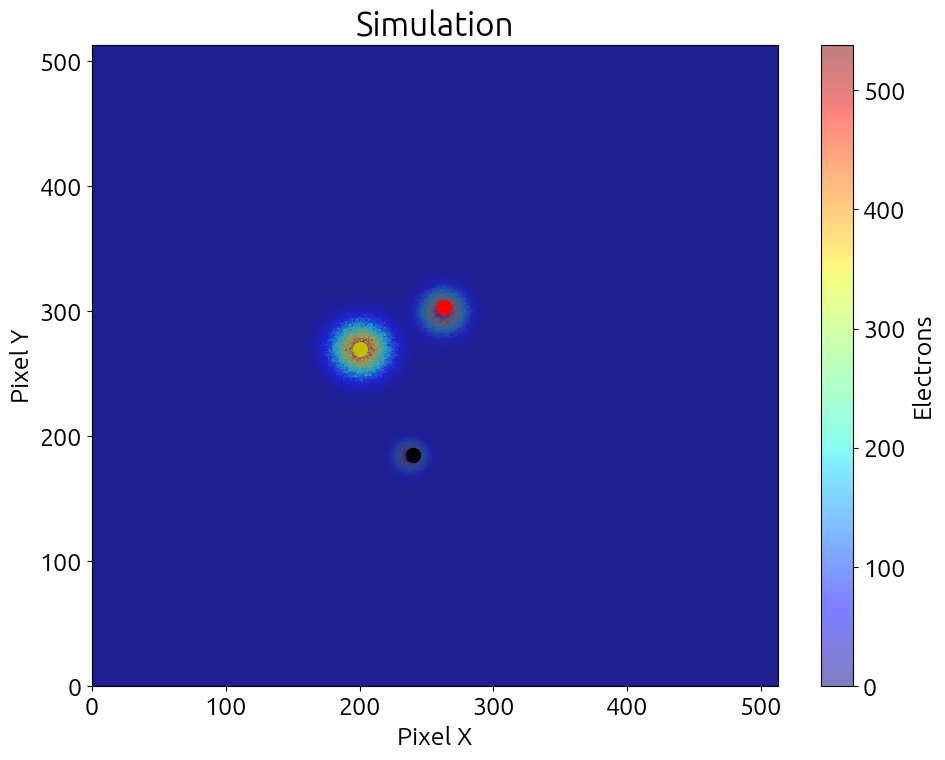

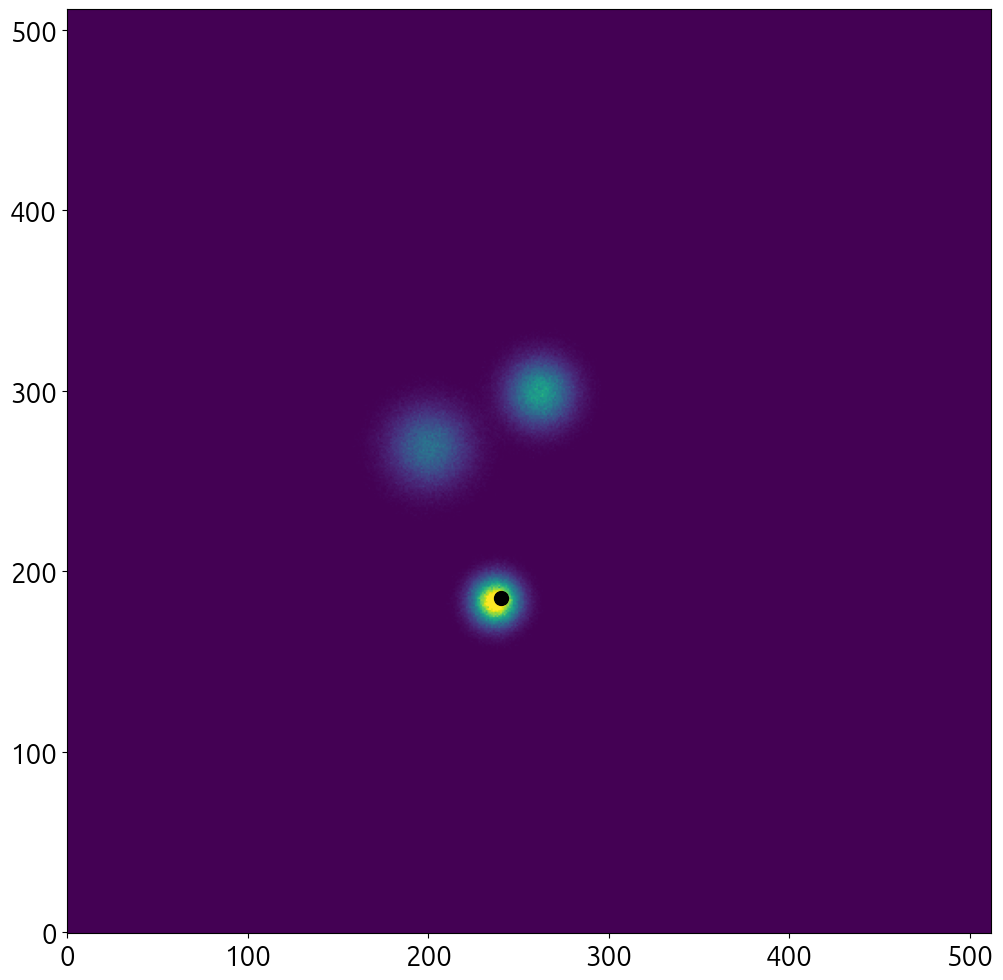

In [12]:
    
pixelSize=16e-3 #mm
Magnefication=16

size=513
bins = [np.linspace(0, size,size), np.linspace(0, size,size)]
#bins=300
cmap = plt.get_cmap('cividis')
cmap = plt.get_cmap('jet')

fig = plt.figure(figsize=(10,8))

ax1 = fig.add_subplot(111)
title=f"Simulation"
ax1.set_title(title)
Shift=[92,92]
PixelX=(Alphas["Alpha1"][0]/(pixelSize*Magnefication)-10+Shift[0])
PixelY=(Alphas["Alpha1"][1]/(pixelSize*Magnefication)-63+Shift[1])    
h1 = ax1.hist2d(PixelX, PixelY, bins=bins, cmap=cmap,alpha=0.5)

PixelX=(Alphas["Alpha2"][0]/(pixelSize*Magnefication)+15+Shift[0])
PixelY=(Alphas["Alpha2"][1]/(pixelSize*Magnefication)+55+Shift[1])    
h2 = ax1.hist2d(PixelX, PixelY, bins=bins, cmap=cmap,alpha=0.5)

PixelX=(Alphas["Alpha3"][0]/(pixelSize*Magnefication)-43+Shift[0])
PixelY=(Alphas["Alpha3"][1]/(pixelSize*Magnefication)+22+Shift[1])
h3 = ax1.hist2d(PixelX, PixelY, bins=bins, cmap=cmap,alpha=0.5)

print(h1[0])
CenterPoint=(200,270)
plt.scatter(*CenterPoint,s=100,color="y",marker="o") ##  15cm


CenterPoint=(263,303)
#Needle10cm_Mask=MaskCreate(PixelShape,20,CenterPoint)
plt.scatter(*CenterPoint,s=100,color="r",marker="o") ##  10cm


CenterPoint=(240,185)

#Needle5cm_Mask=MaskCreate(PixelShape,20,CenterPoint)
CenterPoint=(240,185)
plt.scatter(*CenterPoint,s=100,color="k",marker="o") ##  5cm
cbar1 = plt.colorbar(h1[3])
cbar1.set_label('Electrons', fontsize=18)
cbar1.ax.tick_params(labelsize=18)
# cbar1.ax.set_title('Electrons',fontsize=18, rotation=270)

ax1.set_ylabel(r'Pixel Y',fontsize=18)
ax1.set_xlabel(r'Pixel X',fontsize=18)
ax1.tick_params(labelsize=18)
ax1.set_xlim(0,size)
ax1.set_ylim(0,size)

plt.tight_layout()
# plt.savefig("Reco_Hist.png",dpi=250,bbox_inches='tight')
plt.show()
plt.figure(figsize=(12,12))
image=np.transpose(np.zeros((512,512))+h1[0]+h2[0]+h3[0])
CenterPoint=(240,185)
plt.scatter(*CenterPoint,s=100,color="k",marker="o") ##  5cm
plt.imshow(image,origin="lower",vmin=np.mean(image),vmax=0.8*np.max(image))
Needle1=MaskCreate(h1[0].shape,50,(200,270))[1]*image
Needle2=MaskCreate(h2[0].shape,50,(263,303))[1]*image
Needle3=MaskCreate(h3[0].shape,10,(240,185))[1]*image

#plt.imshow(Needle1[1]*Needle2[1]*Needle3[1]*image)

In [13]:
#plt.figure(figsize=(15,15),dpi=300)
#Mask=Needle1>0
#plt.hist(Needle1[Mask].ravel(),bins=100)
#Mask=Needle2>0
#plt.hist(Needle2[Mask].ravel(),bins=100,alpha=0.5)
#Mask=Needle3>0
#plt.hist(Needle3[Mask].ravel(),bins=100,alpha=0.5)


In [14]:
### Fitting 2D Gaussian
x = np.linspace(0, 512, 512)
xx, yy = np.meshgrid(x, x)

In [15]:

vv=SingleFitImage(image,(200,270),(263,303),(240,185))


/tmp/argon/opticks/ipykernel_51064/4144578757.py:77: RuntimeWarning: invalid value encountered in sqrt
  Intercept=np.round(np.sqrt(intercept),2)


8.403720696791558 8.410096533750426
11.706611068823243 11.879890565757783
14.335225852089277 14.180182636140673
Simulation Value for DT is 0.92 mm/sqrt(cm) with 4e7 collisions
 
Needle Distance is 5.46 cm
DT is 0.58 mm/sqrt(cm) error is 37.0 %
Needle Distance is 10.58 cm
DT is 0.58 mm/sqrt(cm) error is 37.0 %
Needle Distance is 15.55 cm
DT is 0.58 mm/sqrt(cm) error is 37.0 %


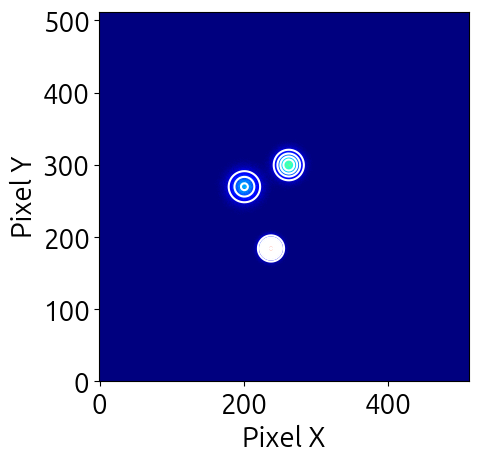

In [16]:
Fit_3Gaussian=vv[3]
#ax[0].imshow(firstFit[0], cmap=plt.cm.jet, origin='lower',extent=(xx.min(), xx.max(), yy.min(), yy.max()))
plt.imshow(Fit_3Gaussian[0], cmap=plt.cm.jet, origin='lower',vmin=np.mean(image),vmax=np.max(image))
plt.contour(Fit_3Gaussian[2][0], Fit_3Gaussian[2][1], Fit_3Gaussian[1], 10, colors='w')

plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

#print(Fit_3Gaussian[3])
print(Fit_3Gaussian[3][2],Fit_3Gaussian[3][4])
print(Fit_3Gaussian[3][2+5],Fit_3Gaussian[3][4+5])
print(Fit_3Gaussian[3][2+10],Fit_3Gaussian[3][4+10])


#print("Converting...")
print(f"Simulation Value for DT is 0.92 mm/sqrt(cm) with 4e7 collisions")
print(" ")
ConvertToDiffusion(Fit_3Gaussian[3][2],Fit_3Gaussian[3][4],5.46,pixelSize,10)
ConvertToDiffusion(Fit_3Gaussian[3][2+5],Fit_3Gaussian[3][4+5],10.58,pixelSize,10)
ConvertToDiffusion(Fit_3Gaussian[3][2+10],Fit_3Gaussian[3][4+10],15.55,pixelSize,10)

fig = plt.figure(figsize=(12,7),dpi=300)
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(xx, yy, data_fitted.reshape(512, 512),cmap="jet")
plt.show()

AttributeError: 'Gas_Properties' object has no attribute 'Vd'

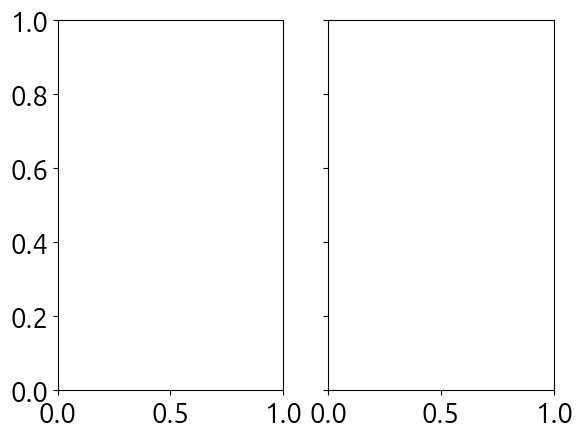

In [17]:
### Extrating Diffusion

dz=np.random.normal(np.mean(Alphas["Alpha1"][2]),np.std(Alphas["Alpha1"][2]),10000)

fig, ax = plt.subplots(1, 2,sharey=True)

SigmaZ=round((np.std(Alphas["Alpha1"][2])/np.sqrt(5.46))*GasProps.Vd,2)

print(f"Expected Transverse Diffusion is {round((SigmaX+SigmaY)/2,3)} ")
print(f"Error is {round(((SigmaX+SigmaY)/2-0.92)/0.92,4)*100}")

count, bins = np.histogram(dx, 1000, density=True)

ax[1].set_title(title)

ax[1].plot(bins, gaussian1d(popt[3],popt[4],bins) ,
         linewidth=2, color='r')
plt.show()
title=f"Dz= {SigmaZ} mm/sqrt(cm)"
plt.title(title)
plt.xlabel("Time (us)")
count, bins,__ = plt.hist(dz,1000,density=True)


plt.plot(bins,gaussian1d(np.mean(Alphas["Alpha1"][2]),np.std(Alphas["Alpha1"][2]),bins),linewidth=2, color='r')
plt.show()


In [ ]:
### GEANT4



In [ ]:
filePath="/media/ilker/Ilker/SimResults/Jan_20_2022/Alpha_Prediction.h5"


data=getvalues(filePath)

In [ ]:
Alphaies=ionizationElectronPosition(data,b'alpha',b'EL_GAP',100)

In [ ]:
for Event in Alphaies.keys():
    X=(Alphaies[Event][0])/10
    Y=Alphaies[Event][1]/10
    bins = [np.arange(-10, 10, 0.02), np.arange(-10, 10, 0.02)]
    cmap = plt.get_cmap('cividis')
    cmap = plt.get_cmap('afmhot')

    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(111)
    #ax1.set_title("GEANT4 Diffusion at 5cm")


    h1 = ax1.hist2d(X, Y, bins=bins, cmap=cmap)

    #cbar1 = plt.colorbar(h1[3])
    #cbar1.set_label('Electrons', fontsize=18)
    #cbar1.ax.tick_params(labelsize=18)
    # cbar1.ax.set_title('Electrons',fontsize=18, rotation=270)

    #ax1.set_ylabel(r'Y  [cm]',fontsize=18)
    #ax1.set_xlabel(r'X  [cm]',fontsize=18)
    #ax1.tick_params(labelsize=18)
    ax1.set_xlim(-10,10)
    ax1.set_ylim(-10,10)
    plt.axis('off')
    path="/media/ilker/Ilker/SimResults/Jan_20_2022/Particles/Predictions/Alpha/Alphas_"+str(Event)+".png"
    plt.tight_layout()
    plt.savefig(path,dpi=300,bbox_inches='tight')
    #plt.show()
    plt.close()

In [ ]:
filePath="/media/ilker/Ilker/SimResults/Jan_20_2022/Betas_Prediction.h5"
data=getvalues(filePath)

In [ ]:
Betas=ionizationElectronPosition(data,b'e-',b'EL_GAP',500)

In [ ]:
print(Betas)


In [ ]:
for Event in Betas.keys():
    X=(Betas[Event][0])/10
    Y=Betas[Event][1]/10
    bins = [np.arange(-10, 10, 0.02), np.arange(-10, 10, 0.02)]
    cmap = plt.get_cmap('cividis')
    cmap = plt.get_cmap('afmhot')

    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(111)
    #ax1.set_title("GEANT4 Diffusion at 5cm")


    h1 = ax1.hist2d(X, Y, bins=bins, cmap=cmap)

    #cbar1 = plt.colorbar(h1[3])
    #cbar1.set_label('Electrons', fontsize=18)
    #cbar1.ax.tick_params(labelsize=18)
    # cbar1.ax.set_title('Electrons',fontsize=18, rotation=270)

    #ax1.set_ylabel(r'Y  [cm]',fontsize=18)
    #ax1.set_xlabel(r'X  [cm]',fontsize=18)
    #ax1.tick_params(labelsize=18)
    ax1.set_xlim(-10,10)
    ax1.set_ylim(-10,10)
    plt.axis('off')
    #path="/media/ilker/Ilker/SimResults/Jan_20_2022/Particles/Predictions/Beta/Betas_"+str(Event)+".png"
    plt.tight_layout()
    plt.savefig(path,dpi=300,bbox_inches='tight')
    #plt.show()
    plt.close()

In [ ]:
#### 